In [21]:
import pandas as pd
import numpy as np
import os, os.path
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix

num_classes = 17
img_size = 64 
batch_size = 8

train_data_dir = './17_flowers/train'
test_data_dir = './17_flowers/validation'

#To identify the number of files in the directory
# list = os.listdir(train_data_dir + '/daisy')
# num_files = len(list)
# print (num_files)

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    width_shift_range = 0.3,
    height_shift_range = 0.3,
    horizontal_flip = True,
    fill_mode = 'nearest')

validation_datagen = ImageDataGenerator(
    rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_size,img_size),
    batch_size = batch_size,
    class_mode = 'categorical')

validation_generator = validation_datagen.flow_from_directory(
    test_data_dir,
    target_size = (img_size,img_size),
    batch_size = batch_size,
    class_mode = 'categorical')


Found 1190 images belonging to 17 classes.
Found 170 images belonging to 17 classes.


## Model from scratch

In [22]:
def create_model_from_scratch():
    
    model = Sequential()
    
    model.add(Conv2D(32, (3,3), padding = 'same', input_shape = (img_size, img_size, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(Conv2D(32, (3,3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(MaxPooling2D(pool_size = (2, 2)))
#     model.add(Dropout(0.5))
    
    model.add(Conv2D(64, (3,3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(Conv2D(64, (3,3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, (3,3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(Conv2D(128, (3,3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
     
    model.add(MaxPooling2D(pool_size = (2, 2)))
    
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(num_classes))
    model.add(Activation("softmax"))
    
    print(model.summary())
    
    return model

In [23]:
scratch_model = create_model_from_scratch()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
activation_19 (Activation)   (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
activation_20 (Activation)   (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 32)       

## Training the model


In [24]:
nb_train_samples = 1190 
nb_validation_samples = 170 
epochs = 50

checkpoint = ModelCheckpoint("/home/deeplearningcv/Practice Projects/Flower Classifier/classified_flowers_vgg.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.00001)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint, reduce_lr]

scratch_model.compile(loss = 'categorical_crossentropy',
             optimizer = Adam(lr = 0.001),
             metrics = ['accuracy'])

history = scratch_model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size
)

# print('Test Loss: ', scores[0])
# print('Test Accuracy: ', scores[1])

Epoch 1/50
148/148 [==============================] - 42s 285ms/step - loss: 3.1842 - accuracy: 0.1523 - val_loss: 7.6641 - val_accuracy: 0.0238
Epoch 2/50
148/148 [==============================] - 40s 267ms/step - loss: 2.7623 - accuracy: 0.1802 - val_loss: 5.2925 - val_accuracy: 0.0494
Epoch 3/50
148/148 [==============================] - 46s 309ms/step - loss: 2.5449 - accuracy: 0.2276 - val_loss: 2.4942 - val_accuracy: 0.2469
Epoch 4/50
148/148 [==============================] - 42s 287ms/step - loss: 2.2820 - accuracy: 0.2800 - val_loss: 2.2789 - val_accuracy: 0.3333
Epoch 5/50
148/148 [==============================] - 41s 275ms/step - loss: 2.2442 - accuracy: 0.2783 - val_loss: 2.9838 - val_accuracy: 0.3333
Epoch 6/50
148/148 [==============================] - 44s 296ms/step - loss: 2.0938 - accuracy: 0.3215 - val_loss: 2.8427 - val_accuracy: 0.4506
Epoch 7/50
148/148 [==============================] - 41s 279ms/step - loss: 2.0946 - accuracy: 0.3291 - val_loss: 3.8756 - val_ac

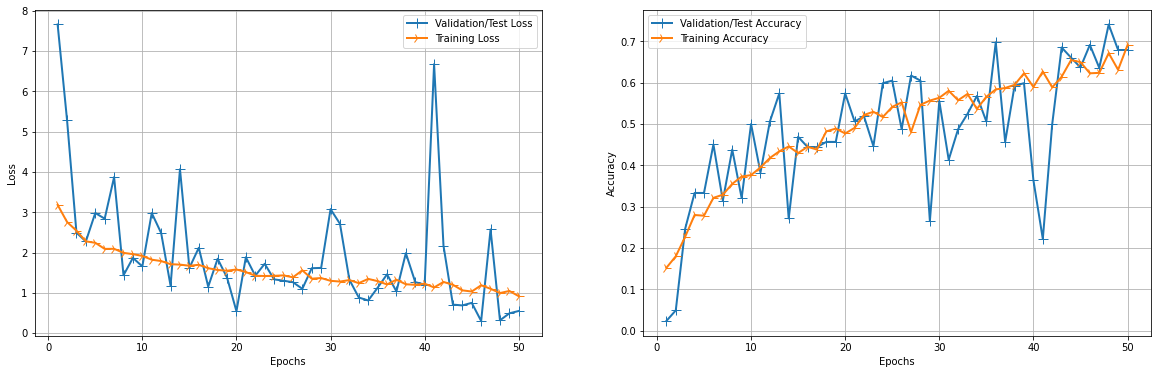

<Figure size 432x288 with 0 Axes>

In [25]:

history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(20,6))

plt.subplot(1,2,1)
line1 = plt.plot(epochs, val_loss_values, label='Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.grid(True)
plt.legend()


plt.subplot(1,2,2)
line1 = plt.plot(epochs, val_acc_values, label='Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label='Training Accuracy')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

plt.tight_layout()


## Performance Analysis


Found 170 images belonging to 17 classes.
Confusion Matrix
[[ 8  0  0  0  0  0  0  0  1  0  0  0  1  0  0  0  0]
 [ 0  5  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  5  0  0  0  0  4  0  0  0  0  0  0  1  0  0]
 [ 0  2  1  2  0  3  0  0  0  0  0  0  0  0  0  2  0]
 [ 1  0  0  0  7  0  0  0  1  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  9  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  9  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 10  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  3  5  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  4  0  3  0  0  0  3]
 [ 0  1  0  0  0  0  1  0  0  0  0  7  0  0  0  0  1]
 [ 1  0  0  0  0  0  0  0  0  0  3  0  6  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 10  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 10  0  0]
 [ 0  1  0  1  0  4  0  0  0  0  0  0  0  2  1  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 10]]
Classification Report


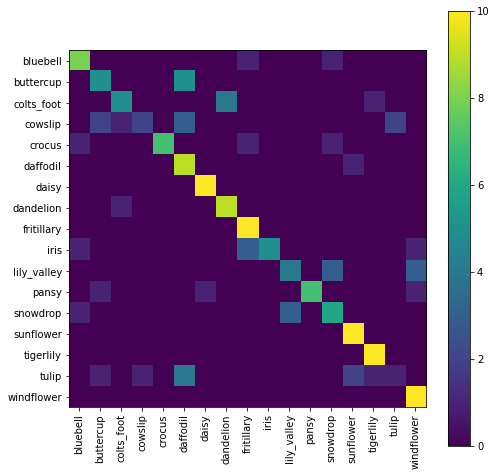

In [26]:
nb_train_samples = 1190 
nb_validation_samples = 170 

validation_generator = validation_datagen.flow_from_directory(
    test_data_dir,
    target_size = (img_size,img_size),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle=False)


class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())


#Confution Matrix and Classification Report
Y_pred = scratch_model.predict_generator(validation_generator, nb_validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred)

plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)